In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import Module, Sequential, Linear, Conv2d, ReLU, Tanh, Dropout, BatchNorm1d
from torch.utils.data import DataLoader
from torch import optim
from torch.nn.functional import normalize

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from torch.distributions.multivariate_normal import MultivariateNormal

from ignite.metrics import FID

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
load_size = 1   #len: 5918
num_samples_train = 5000

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])

train_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=True,
    transform=transform,
)

train_dataset.data = train_dataset.data[train_dataset.targets == 6]
train_dataset.targets = train_dataset.targets[train_dataset.targets == 6]

test_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=load_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=load_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [4]:
train_dataset_target = None
for batch in train_dataloader:
    train_dataset_target = batch[0].reshape(-1, 32*32).to(device).repeat(num_samples_train,1)
    break
print(train_dataset_target.shape)

torch.Size([5000, 1024])


In [5]:
normal_init = MultivariateNormal(torch.tensor([[0 for i in range(32*32)]]).float(), 0.15*torch.stack([torch.eye(32*32) for i in range(1)]))
# train_dataset_init=(normal_init.sample([num_samples_train]).to(device).reshape(-1, 32*32))
# train_dataset_init = torch.where(train_dataset_init < -1, -1, train_dataset_init)
# train_dataset_init = torch.where(train_dataset_init > 1, 1, train_dataset_init)
train_dataset_init=torch.randn((num_samples_train, 32*32)).to(device) / 3
pairs_1 = torch.stack([train_dataset_init, train_dataset_target], axis=1)

In [6]:
class v_model(Module):
    def __init__(self, input_dim, layers, hidden_num):
        super().__init__()
        self.input_dim = input_dim
        self.input_dim = hidden_num

        p_drop = 0.2
        self.NN = Sequential(Linear(input_dim + 1, hidden_num, bias=True),
                            ReLU(),
                            BatchNorm1d(hidden_num)
                            )

        for layer in range(layers):
            self.NN.append(Dropout(p_drop))
            self.NN.append(Linear(hidden_num, hidden_num, bias=True))
            self.NN.append(ReLU())
            self.NN.append(BatchNorm1d(hidden_num))
        self.NN.append(Dropout(p_drop))
        self.NN.append(Linear(hidden_num, input_dim, bias=True))


    def forward(self, x_input, t):
        inputs = torch.cat([x_input, t], dim=1)
        x = self.NN(inputs)

        return x

In [7]:
class RectifiedFlow(Module):
    def __init__(self, v_model):
        super().__init__()
        self.v_model = v_model.to(device)
        self.loss_curve = []
        self.test_loss_curve = []

    def get_train_tuple(self, z0, z1):
        # random times
        t = torch.rand((z0.shape[0], 1)).to(device)
        # linear interpolation
        z_t = t* z1 + (1-t) * z0
        # connection line
        target = z1 - z0

        return z_t, t, target

    @torch.no_grad()
    def sample_ode(self, z0, num_steps):
        trajectory = []
        trajectory.append(z0.detach().clone())

        batchsize = z0.shape[0]

        dt = 1./num_steps
        z = z0.detach().clone()
        for i in range(num_steps):
            t = torch.ones((batchsize, 1)).to(device) * i /num_steps
            pred = self.v_model(z, t)
            z = z.detach().clone() + pred * dt

            trajectory.append(z.detach().clone())

        return trajectory

In [8]:
def rematch_pairs(pairs):
    indeces_1 = torch.randperm(len(pairs))
    indeces_2 = torch.randperm(len(pairs))
    z0 = pairs[:, 0][indeces_1]
    z1 = pairs[:, 1][indeces_2]
    rematched_pairs = torch.stack([z0, z1], axis=1)
    return rematched_pairs

In [9]:
def train_rectified_flow(rectified_flow, optimizer, scheduler, pairs, test_pairs, batchsize, iterations):
    loss_curve = rectified_flow.loss_curve
    test_loss_curve = rectified_flow.test_loss_curve
    test_loss = 1400
    for i in range(iterations + 1):
        optimizer.zero_grad()
        #pairs = rematch_pairs(pairs)
        indeces = torch.randperm(len(pairs))[:batchsize]
        batch = pairs[indeces]
        z0 = batch[:, 0]
        z1 = batch[:, 1]
        z_t, t, target = rectified_flow.get_train_tuple(z0, z1)

        pred = rectified_flow.v_model(z_t, t)
        loss = (target- pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
        loss = loss.mean()
        loss.backward()

        optimizer.step()
        loss_curve.append(loss.item())
        scheduler.step(loss.item())

        if i % 100 == 0:
            indeces = torch.randperm(len(pairs))[:batchsize]
            batch = test_pairs[indeces]
            z0 = batch[:, 0]
            z1 = batch[:, 1]
            t = torch.ones((batchsize, 1)).to(device)
            target = z1 - z0

            pred = rectified_flow.v_model(z_t, t)
            test_loss = (target- pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
            test_loss = test_loss.mean()
        test_loss_curve.append(test_loss.item())

    rectified_flow.loss_curve = loss_curve
    rectified_flow.test_loss_curve = test_loss_curve
    return rectified_flow, loss_curve, test_loss_curve

In [10]:
v_mod = v_model(input_dim=32*32,layers=2, hidden_num=32*112)
rectified_flow_1 = RectifiedFlow(v_mod)

In [11]:
normal_init = MultivariateNormal(torch.tensor([[0 for i in range(32*32)]]).float(), 0.15*torch.stack([torch.eye(32*32) for i in range(1)]))
test_dataset_init=(normal_init.sample([num_samples_train]).to(device).reshape(-1, 32*32))
# test_dataset_init = torch.where(train_dataset_init < -1, -1, train_dataset_init)
# test_dataset_init = torch.where(train_dataset_init > 1, 1, train_dataset_init)
test_pairs_1 = torch.stack([test_dataset_init, train_dataset_target], axis=1)

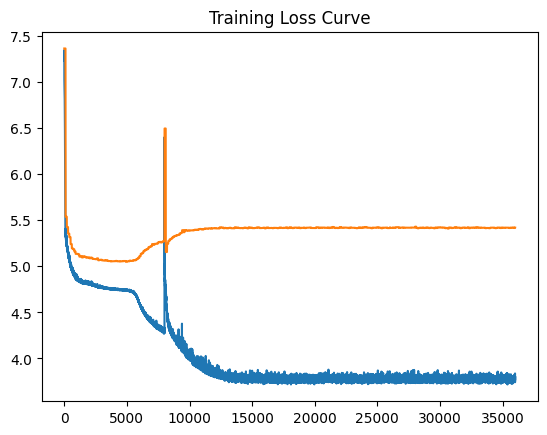

In [23]:
#optimizer_1 = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=5e-6)
#scheduler_1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, factor=0.8, patience=100, verbose=True)

rectified_flow_1, loss_curve_1, test_loss_curve_1 = train_rectified_flow(rectified_flow_1, optimizer_1, scheduler_1, pairs_1,test_pairs_1,batchsize=512, iterations=10000)
plt.plot(np.log(loss_curve_1))
plt.plot(np.log(test_loss_curve_1))
plt.title("Training Loss Curve")
plt.show()

In [19]:
scheduler_1.state_dict()

{'factor': 0.8,
 'min_lrs': [0],
 'patience': 100,
 'verbose': False,
 'cooldown': 0,
 'cooldown_counter': 0,
 'mode': 'min',
 'threshold': 0.0001,
 'threshold_mode': 'rel',
 'best': 41.284934997558594,
 'num_bad_epochs': 0,
 'mode_worse': inf,
 'eps': 1e-08,
 'last_epoch': 8001,
 '_last_lr': [5.316911983139676e-08]}

62.65203729036493
41.14118957519531
--
217.24887568413178


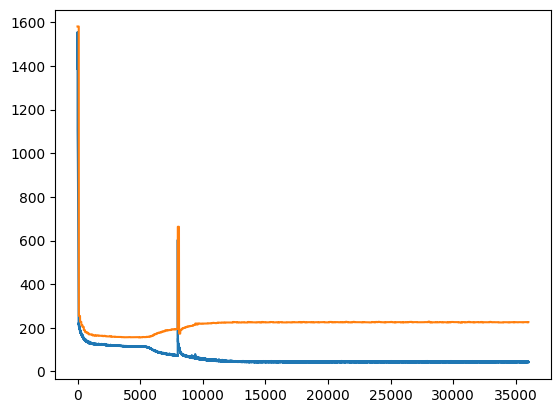

In [24]:
plt.plot(rectified_flow_1.loss_curve)
plt.plot(rectified_flow_1.test_loss_curve)
print(np.mean(rectified_flow_1.loss_curve[:-200]))
print(np.min(rectified_flow_1.loss_curve))
print("--")
print(np.mean(rectified_flow_1.test_loss_curve[:-20]))

tensor(-0.0003, device='cuda:0')
tensor(0.3334, device='cuda:0')
tensor(-0.7132, device='cuda:0')
tensor(0.5641, device='cuda:0')
tensor(-0.7088, device='cuda:0')
tensor(0.5933, device='cuda:0')


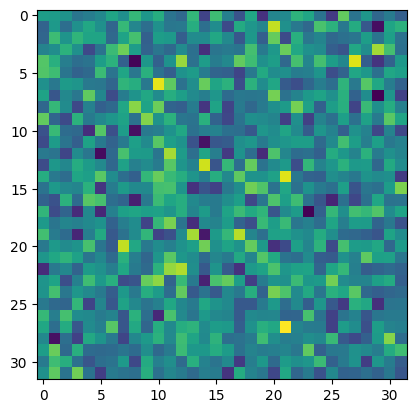

tensor([[-1.0000, -0.8031, -0.8739,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.8704, -0.8766],
        [-1.0000, -0.8131, -1.0000,  ..., -1.0000, -0.7377, -1.0000],
        ...,
        [-0.8124, -0.8890, -1.0000,  ..., -1.0000, -0.8722, -1.0000],
        [-1.0000, -0.8216, -0.8026,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -0.5735, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
       device='cuda:0')


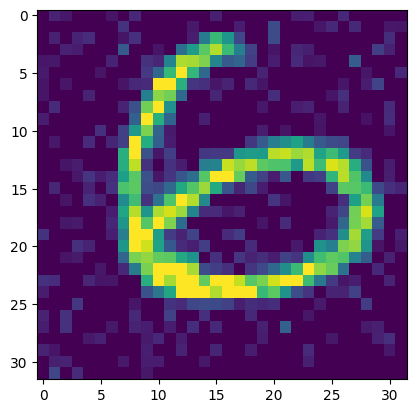

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]], device='cuda:0')


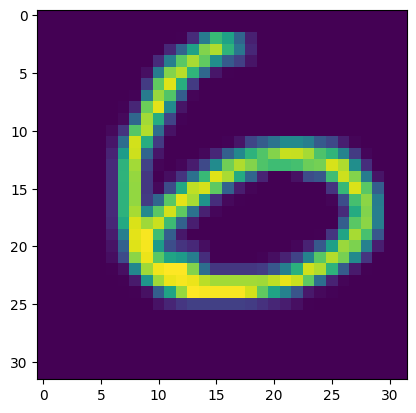

In [29]:
curr_img = 1
img = rectified_flow_1.sample_ode(pairs_1[:10, 0], 100)
print(torch.mean(pairs_1[:, 0]))
print(torch.std(pairs_1[:, 0]))
print(torch.mean(pairs_1[:, 1]))
print(torch.std(pairs_1[:, 1]))
print(torch.mean(img[-1][:]))
print(torch.std(img[-1][:]))
plt.imshow(pairs_1[curr_img, 0].reshape(32,32).detach().cpu().numpy())
plt.show()
img[-1] = torch.where(img[-1] < -0.9, -1, img[-1])
img[-1] = torch.where(img[-1] > 0.9, 1, img[-1])
plt.imshow(img[-1][curr_img].reshape(32,32).detach().cpu().numpy())
print(img[-1][curr_img].reshape(32,32))
plt.show()
plt.imshow(pairs_1[curr_img, 1].reshape(32,32).detach().cpu().numpy())
print(pairs_1[curr_img, 1].reshape(32,32))
plt.show()

In [19]:
from ignite.engine import Engine
def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

metric = FID(num_features=32*32)
metric.attach(default_evaluator, "fid")
y_true = train_dataset_target[:10].detach().clone().cpu()
y_pred = img[-1]
state = default_evaluator.run([[y_pred, y_true]])
print(state.metrics["fid"])
print(train_dataset_target.shape)

125.95523010331841
torch.Size([5000, 1024])


/home/max/anaconda3/envs/ML/lib/python3.9/site-packages/scipy/linalg/_matfuncs_sqrtm.py:189: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


In [13]:
train_dataset_init=(normal_init.sample([num_samples_train]).to(device).reshape(-1, 32*32))
train_dataset_init = torch.where(train_dataset_init < -1, -1, train_dataset_init)
train_dataset_init = torch.where(train_dataset_init > 1, 1, train_dataset_init)

flow_1 = rectified_flow_1.sample_ode(train_dataset_init, 100)
pairs_2 = torch.stack([train_dataset_init, flow_1[-1]], axis=1)

In [14]:
v_mod_2 = v_model(input_dim=32*32,layers=11, hidden_num=32*32)
rectified_flow_2 = RectifiedFlow(v_mod_2)

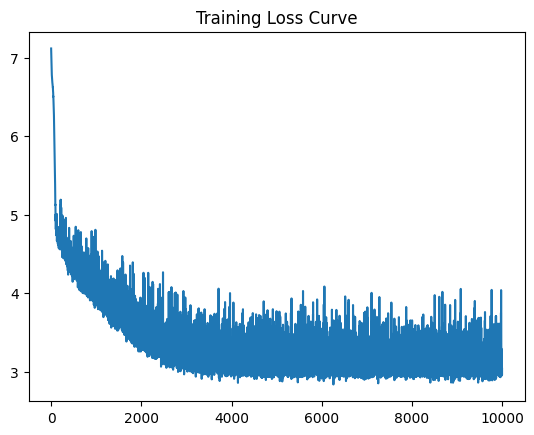

In [15]:
optimizer_2 = torch.optim.Adam(rectified_flow_2.v_model.parameters(), lr=5e-4)
scheduler_2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_2, factor=0.8, patience=100, verbose=False)

rectified_flow_2, loss_curve_2 = train_rectified_flow(rectified_flow_2, optimizer_2, scheduler_2, pairs_2,batchsize=256, iterations=10000)
plt.plot(np.log(loss_curve_2))
plt.title("Training Loss Curve")
plt.show()

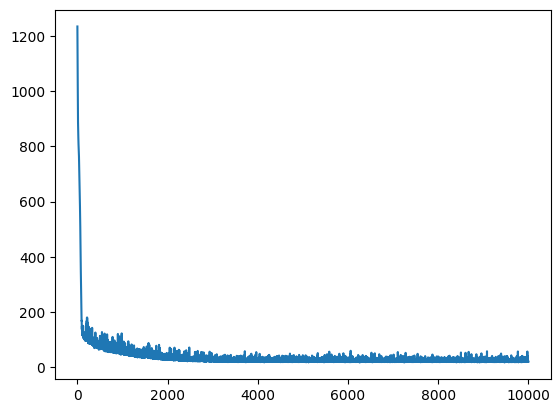

In [17]:
plt.plot(rectified_flow_2.loss_curve)

tensor(0.0006, device='cuda:0')
tensor(0.3838, device='cuda:0')
tensor(-0.7230, device='cuda:0')
tensor(0.6863, device='cuda:0')
tensor(-0.7235, device='cuda:0')
tensor(0.7431, device='cuda:0')


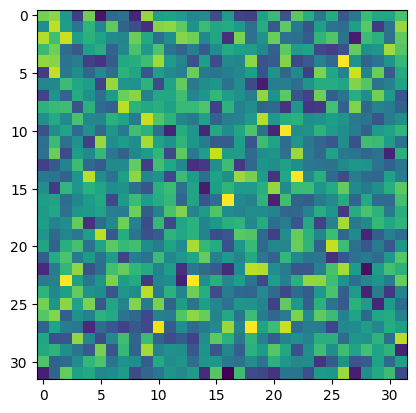

tensor([[-0.4975,  0.0429, -0.6852,  ..., -0.5639, -0.7136, -0.2066],
        [-0.8337, -0.1510, -0.8038,  ..., -1.3713, -1.1044, -0.2638],
        [-0.0058, -0.3831, -0.0365,  ..., -0.7105, -0.9715, -0.4614],
        ...,
        [-0.6693, -0.2114, -0.8748,  ..., -0.6673, -0.4725, -1.7221],
        [-0.2136, -1.3657, -1.0924,  ..., -0.6425, -1.0402, -0.8384],
        [-1.6026, -1.2808, -0.3271,  ..., -0.7375, -0.6306, -1.3915]],
       device='cuda:0')


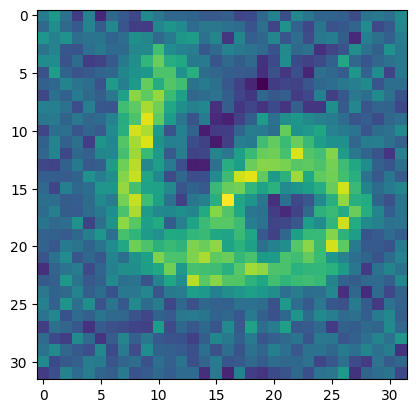

tensor([[-0.3889, -0.2644, -0.8368,  ..., -0.8991, -0.8262, -0.4452],
        [-0.9433, -0.3063, -0.8738,  ..., -1.6714, -1.2492, -0.4490],
        [-0.2121, -0.6619, -0.1745,  ..., -0.7397, -1.1489, -0.4578],
        ...,
        [-0.7273, -0.7368, -1.0259,  ..., -0.8280, -0.9230, -1.7809],
        [-0.6153, -1.2763, -1.2360,  ..., -0.8310, -1.2565, -0.8375],
        [-1.8230, -1.3456, -0.4331,  ..., -0.6828, -0.8010, -1.5838]],
       device='cuda:0')


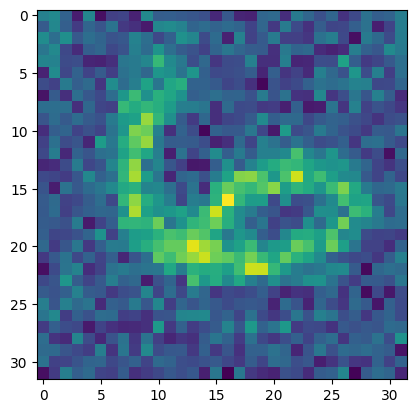

In [22]:
curr_img = 5
img = rectified_flow_2.sample_ode(pairs_2[:10, 0], 100)
print(torch.mean(pairs_2[:, 0]))
print(torch.std(pairs_2[:, 0]))
print(torch.mean(pairs_2[:, 1]))
print(torch.std(pairs_2[:, 1]))
print(torch.mean(img[-1][:]))
print(torch.std(img[-1][:]))
plt.imshow(pairs_2[curr_img, 0].reshape(32,32).detach().cpu().numpy())
plt.show()
plt.imshow(img[-1][curr_img].reshape(32,32).detach().cpu().numpy())
print(img[-1][curr_img].reshape(32,32))
plt.show()
plt.imshow(pairs_2[curr_img, 1].reshape(32,32).detach().cpu().numpy())
print(pairs_2[curr_img, 1].reshape(32,32))
plt.show()

In [23]:
train_dataset_init=(normal_init.sample([num_samples_train]).to(device).reshape(-1, 32*32))
train_dataset_init = torch.where(train_dataset_init < -1, -1, train_dataset_init)
train_dataset_init = torch.where(train_dataset_init > 1, 1, train_dataset_init)

flow_2 = rectified_flow_1.sample_ode(train_dataset_init, 100)
pairs_3 = torch.stack([train_dataset_init, flow_2[-1]], axis=1)

In [24]:
v_mod_3 = v_model(input_dim=32*32,layers=11, hidden_num=32*32)
rectified_flow_3 = RectifiedFlow(v_mod_3)

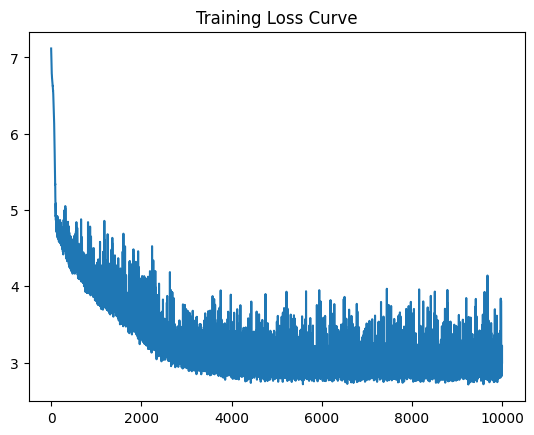

In [25]:
optimizer_3 = torch.optim.Adam(rectified_flow_3.v_model.parameters(), lr=5e-4)
scheduler_3 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_3, factor=0.8, patience=100, verbose=False)

rectified_flow_3, loss_curve_3 = train_rectified_flow(rectified_flow_3, optimizer_3, scheduler_3, pairs_3,batchsize=256, iterations=10000)
plt.plot(np.log(loss_curve_3))
plt.title("Training Loss Curve")
plt.show()

15.070207595825195


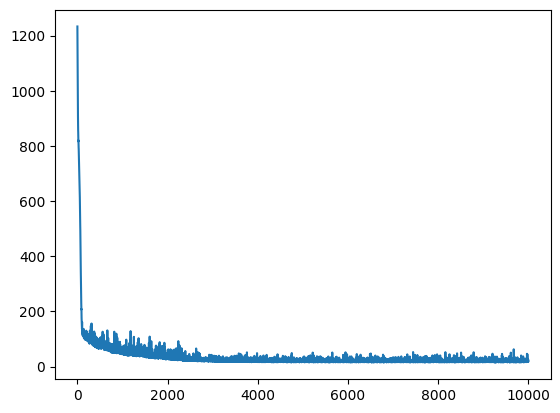

In [33]:
plt.plot(rectified_flow_3.loss_curve)
print(np.min(rectified_flow_3.loss_curve))

tensor(-2.7589e-06, device='cuda:0')
tensor(0.3837, device='cuda:0')
tensor(-0.7236, device='cuda:0')
tensor(0.6867, device='cuda:0')
tensor(-0.7215, device='cuda:0')
tensor(0.7136, device='cuda:0')


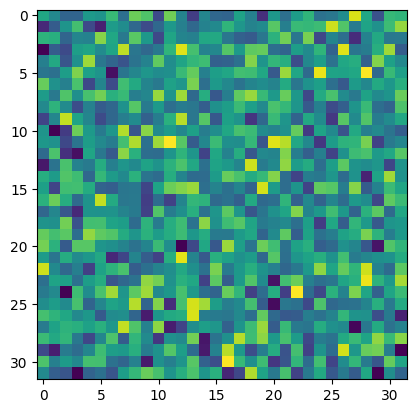

tensor([[-0.7906, -1.1570, -1.4368,  ..., -1.5343, -0.7682, -0.7831],
        [-1.8592, -1.4780, -1.0100,  ..., -1.0509, -0.7742, -0.2964],
        [-0.7065, -0.8683, -1.3319,  ..., -0.7738, -1.3061, -1.2007],
        ...,
        [-1.6459, -1.9249, -1.2188,  ..., -0.5182, -1.2136, -2.0994],
        [-0.6401, -1.0866, -0.9681,  ..., -1.5221, -0.6041, -0.8382],
        [-1.1200, -1.4253, -1.4898,  ..., -2.1351, -1.0705, -1.4336]],
       device='cuda:0')


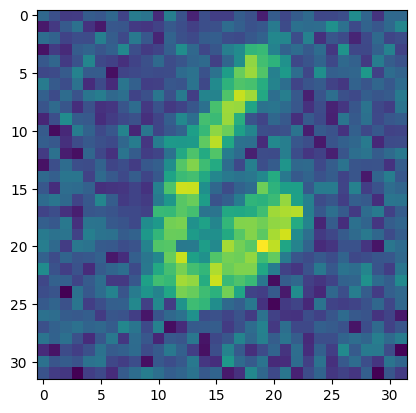

tensor([[-0.7800, -1.1150, -1.3396,  ..., -1.5107, -0.6102, -0.5313],
        [-1.7045, -1.4496, -0.9365,  ..., -0.8517, -0.4875, -0.2488],
        [-0.6561, -0.7611, -1.3110,  ..., -0.7725, -1.2206, -1.1557],
        ...,
        [-1.6735, -1.7999, -1.1850,  ..., -0.4690, -1.2142, -1.9984],
        [-0.6250, -1.1556, -0.8988,  ..., -1.4504, -0.5471, -0.7328],
        [-1.1524, -1.3243, -1.4888,  ..., -2.0607, -1.0458, -1.3645]],
       device='cuda:0')


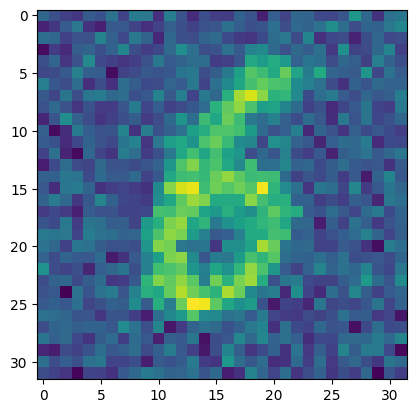

In [31]:
curr_img = 9
img = rectified_flow_2.sample_ode(pairs_3[:10, 0], 100)
print(torch.mean(pairs_3[:, 0]))
print(torch.std(pairs_3[:, 0]))
print(torch.mean(pairs_3[:, 1]))
print(torch.std(pairs_3[:, 1]))
print(torch.mean(img[-1][:]))
print(torch.std(img[-1][:]))
plt.imshow(pairs_3[curr_img, 0].reshape(32,32).detach().cpu().numpy())
plt.show()
plt.imshow(img[-1][curr_img].reshape(32,32).detach().cpu().numpy())
print(img[-1][curr_img].reshape(32,32))
plt.show()
plt.imshow(pairs_3[curr_img, 1].reshape(32,32).detach().cpu().numpy())
print(pairs_3[curr_img, 1].reshape(32,32))
plt.show()